In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

num_classes = 131
img_rows, img_cols = 32, 32
batch_size = 16

from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '../input/fruits/fruits-360/Training'
validation_data_dir = '../input/fruits/fruits-360/Test'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [3]:
## Lets build our model


model = Sequential()

model.add(Conv2D (32, (3,3), padding = 'same', 
                  input_shape = (img_rows, img_cols, 3)))
model.add(Activation('relu'))
model.add(Conv2D (32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))



## using the RMS props optimiser and intialising some parameters
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

print(model.summary())



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [7]:
## Implementing callback functions

from keras.optimizers import RMSprop, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau




earlystop = EarlyStopping(monitor = "val_loss",
                         min_delta = 0,
                         patience = 3,
                         verbose = 1,
                         restore_best_weights = True)


reduce_lr = ReduceLROnPlateau(monitor = "val_loss",
                             factor = 0.2,
                             patience = 3,
                             verbose = 1,
                             min_delta = 0.0001 
                             )


## store the callbacks in a callback list
callbacks = [earlystop, reduce_lr]


## lets compile the model
model.compile(loss = 'categorical_crossentropy',
             optimizer = RMSprop(lr = 0.001),
             metrics = ['accuracy'])


nb_train_samples = 67692
nb_validation_samples = 22688
epochs = 5


history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)


Epoch 1/5
4230/4230 [==============================] - 124s 29ms/step - loss: 0.6393 - accuracy: 0.8209 - val_loss: 0.7072 - val_accuracy: 0.8403 - lr: 0.0010
Epoch 2/5
4230/4230 [==============================] - 122s 29ms/step - loss: 0.6892 - accuracy: 0.8239 - val_loss: 0.5143 - val_accuracy: 0.9041 - lr: 0.0010
Epoch 3/5
4230/4230 [==============================] - 121s 29ms/step - loss: 0.8981 - accuracy: 0.7929 - val_loss: 1.0177 - val_accuracy: 0.7946 - lr: 0.0010
Epoch 4/5
4230/4230 [==============================] - 121s 29ms/step - loss: 1.2851 - accuracy: 0.7375 - val_loss: 1.1724 - val_accuracy: 0.7551 - lr: 0.0010
Epoch 5/5
4230/4230 [==============================] - ETA: 0s - loss: 1.5959 - accuracy: 0.6792Restoring model weights from the end of the best epoch.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
4230/4230 [==============================] - 121s 29ms/step - loss: 1.5959 - accuracy: 0.6792 - val_loss: 0.8975 - val_accuracy: 0

In [8]:
## Displaying the confusion matrix

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

## Confusion matrix and classification report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis = 1)
print("confusion matrix")
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

confusion matrix
[[147   0   0 ...   0   0   0]
 [  0 138   0 ...   0   0   0]
 [  0   0 108 ...   0   0   0]
 ...
 [  0   0   0 ... 152   0   1]
 [  0   0   0 ...   0 249   0]
 [  0   0   0 ...   0   0 157]]
Classification Report
                     precision    recall  f1-score   support

     Apple Braeburn       0.44      0.90      0.59       164
 Apple Crimson Snow       0.99      0.93      0.96       148
     Apple Golden 1       0.76      0.68      0.72       160
     Apple Golden 2       0.98      1.00      0.99       164
     Apple Golden 3       0.63      0.99      0.77       161
 Apple Granny Smith       1.00      0.63      0.77       164
    Apple Pink Lady       0.84      0.88      0.86       152
        Apple Red 1       0.87      0.98      0.92       164
        Apple Red 2       1.00      0.13      0.23       164
        Apple Red 3       1.00      0.92      0.96       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.92      

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


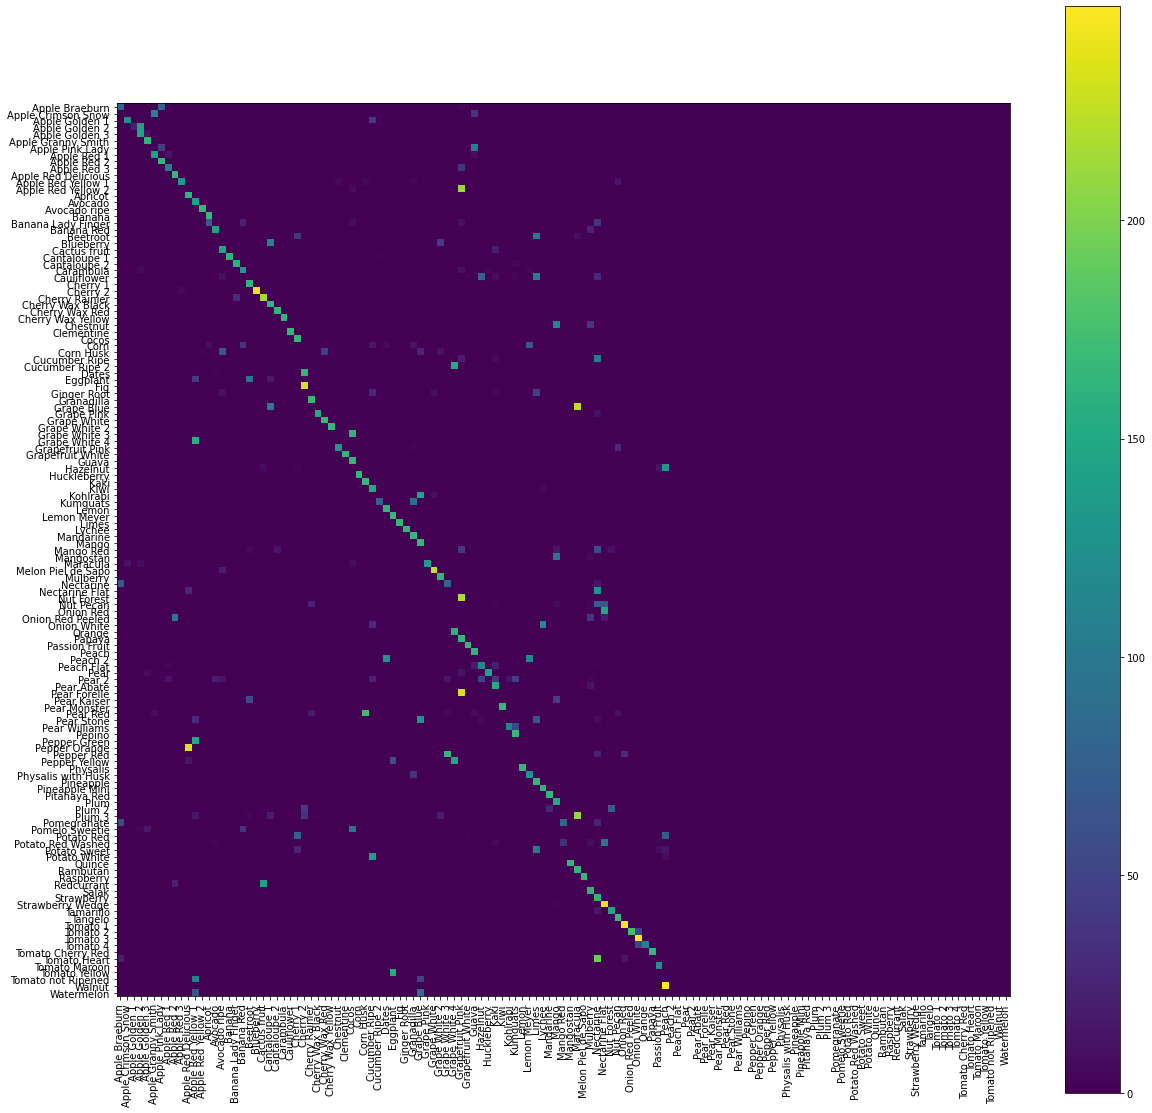

In [10]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

img_row, img_height, img_depth = 32,32,3
model = load_model('../input/model/fruits_fresh_cnn.h5')

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 67692
nb_validation_samples = 22688

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 32, 32


files = []
predictions = []
true_labels = []
# predicting images
for i in range(0, 10):
    path = '../input/fruits/fruits-360/Test/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()